> **Data provenance:** Breast Cancer Wisconsin (Diagnostic) via `sklearn.datasets.load_breast_cancer()`.  
> APA-style: *Wolberg, W. H., & Street, W. N. (1995). Breast Cancer Wisconsin (Diagnostic) Data Set. UCI ML Repository.*  
> 
> **Ethics & Licensing:** Public academic dataset; used for educational purposes. No PII.  
> **Cleaning plan:** Check missing values, data types, outliers; standardize features for linear/SVM models; stratified split to respect class balance.



# Final Project — Supervised Learning: Breast Cancer Classification

**Problem:** Predict whether a tumor is **malignant (1)** or **benign (0)** from diagnostic features (Breast Cancer Wisconsin dataset).  
**Deliverables covered here:** EDA, model building, evaluation, and discussion.

**Why this dataset?** It is widely used, clean, tabular, and small enough for fast iteration while still being realistic.


In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, f1_score)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True


In [2]:

# Load data
ds = load_breast_cancer()
X = pd.DataFrame(ds.data, columns=ds.feature_names)
y = pd.Series(ds.target, name='target')  # 0 = malignant, 1 = benign
target_names = ds.target_names

print('Shape:', X.shape)
print('Target distribution:', y.value_counts(normalize=True).round(3).to_dict())
X.head()


Shape: (569, 30)
Target distribution: {1: 0.627, 0: 0.373}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



### Target Distribution & Outliers (Quick Checks)

- Bar plot of class balance (malignant vs benign).  
- Box-plots for a few high-variance features.  
- Simple outlier count using z-score > 3 (rule-of-thumb).  
- **Transformation note:** models with distance metrics (e.g., SVM) benefit from scaling; heavy skew may motivate a log transform for area-like features.


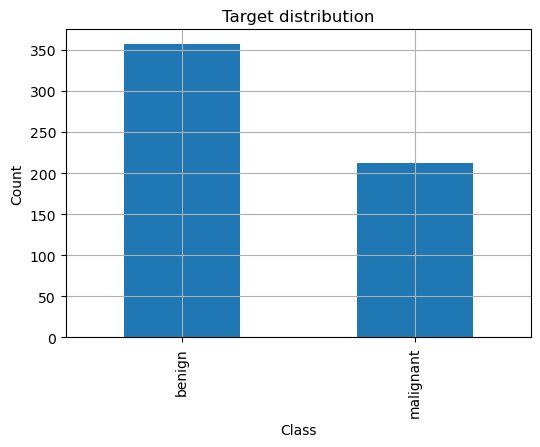

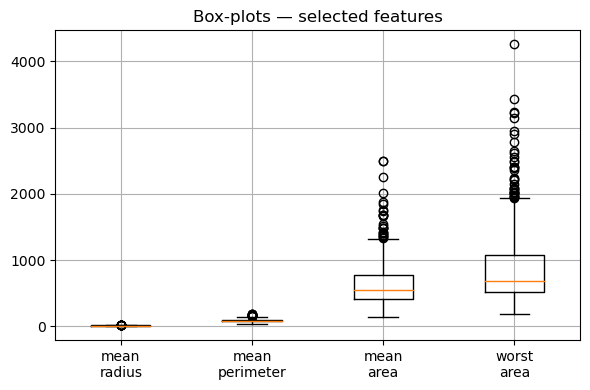

,mean radius,mean perimeter,mean area,worst area
outliers_gt3sigma,5,7,8,10


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Target distribution
counts = y.value_counts().rename(index={0:'malignant',1:'benign'})
counts.plot(kind='bar')
plt.title('Target distribution'); plt.xlabel('Class'); plt.ylabel('Count'); plt.show()

# Box-plots for selected features
features_box = ['mean radius','mean perimeter','mean area','worst area']
plt.figure(figsize=(6,4))
plt.boxplot([X[c] for c in features_box], labels=[c.replace(' ','\n') for c in features_box])
plt.title('Box-plots — selected features'); plt.tight_layout(); plt.show()

# Outlier counts via z-score > 3
from scipy.stats import zscore

z = X[features_box].apply(zscore)
outlier_counts = (np.abs(z) > 3).sum().to_frame('outliers_gt3sigma')
display(outlier_counts.T)



**Cleaning decisions (summary):**  
- No missing values detected; no imputation needed.  
- Standardization is applied within pipelines for linear/SVM models.  
- Outliers exist in area-related features but tree models are robust; monitor their effect on linear decision boundaries.  
- Features show families of high correlation (radius/perimeter/area) → rely on regularization for linear models; feature importance for trees.


## EDA — Structure & Quality Checks

In [4]:

print('Missing values per column (should be 0):')
print(X.isna().sum().sort_values(ascending=False).head())

print('\nSummary stats:')
display(X.describe().T.iloc[:10])


Missing values per column (should be 0):
mean radius             0
mean texture            0
worst symmetry          0
worst concave points    0
worst concavity         0
dtype: int64

Summary stats:


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


### Distributions of selected features

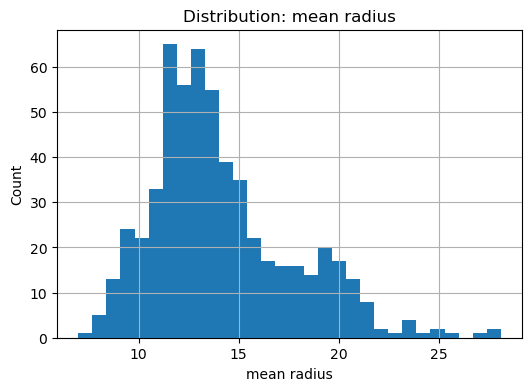

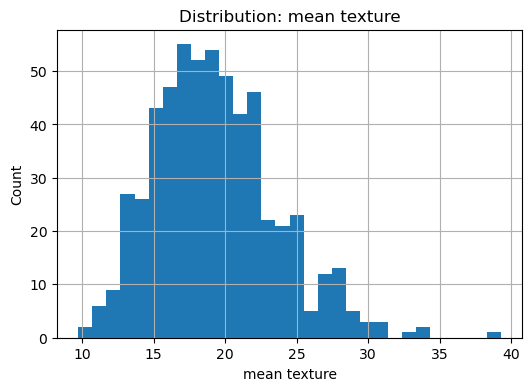

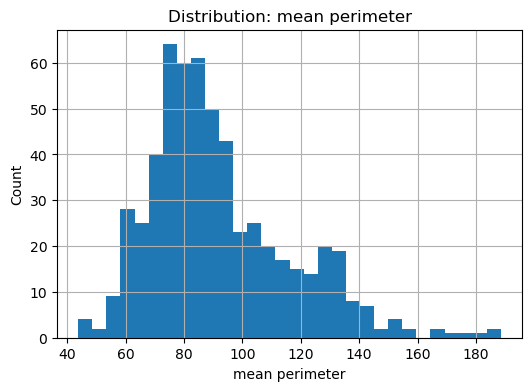

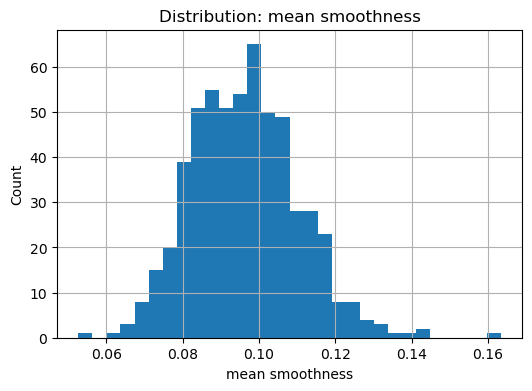

In [5]:

features_to_plot = ['mean radius','mean texture','mean perimeter','mean smoothness']
for col in features_to_plot:
    plt.figure()
    plt.hist(X[col], bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.show()


### Correlation heatmap (top 12 features by variance)

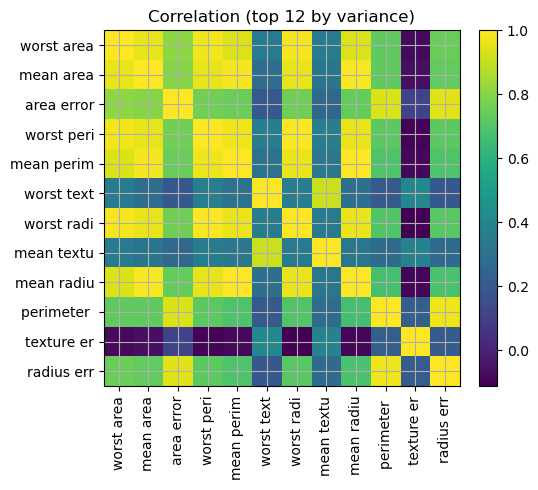

In [6]:

variances = X.var().sort_values(ascending=False)
top_cols = variances.index[:12]
corr = X[top_cols].corr()

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(corr.values, interpolation='nearest')
ax.set_xticks(range(len(top_cols))); ax.set_yticks(range(len(top_cols)))
ax.set_xticklabels([c[:10] for c in top_cols], rotation=90)
ax.set_yticklabels([c[:10] for c in top_cols])
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('Correlation (top 12 by variance)')
plt.tight_layout(); plt.show()


## Modeling — Train/Test Split

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print('Train size:', X_train.shape, ' Test size:', X_test.shape)


Train size: (426, 30)  Test size: (143, 30)


### Baseline (DummyClassifier)

In [8]:

baseline = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print('Baseline accuracy:', round((y_pred_base == y_test).mean(), 3))
print(classification_report(y_test, y_pred_base, digits=3, target_names=['malignant','benign']))


Baseline accuracy: 0.629
              precision    recall  f1-score   support

   malignant      0.000     0.000     0.000        53
      benign      0.629     1.000     0.773        90

    accuracy                          0.629       143
   macro avg      0.315     0.500     0.386       143
weighted avg      0.396     0.629     0.486       143



C:\Users\moham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Candidate Models & 5-Fold CV

In [9]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    'LogReg': Pipeline([('scaler', StandardScaler()),
                        ('clf', LogisticRegression(max_iter=500, random_state=RANDOM_STATE))]),
    'RF': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    'SVC': Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(probability=True, kernel='rbf', random_state=RANDOM_STATE))])
}

scores = []
for name, model in models.items():
    res = cross_validate(model, X_train, y_train, cv=cv,
                         scoring=['accuracy','f1','roc_auc'],
                         return_train_score=False)
    scores.append({
        'model': name,
        'acc_mean': res['test_accuracy'].mean(),
        'f1_mean': res['test_f1'].mean(),
        'roc_auc_mean': res['test_roc_auc'].mean()
    })
scores_df = pd.DataFrame(scores).sort_values('roc_auc_mean', ascending=False)
scores_df.round(3)


,model,acc_mean,f1_mean,roc_auc_mean
0,LogReg,0.979,0.983,0.996
2,SVC,0.967,0.974,0.995
1,RF,0.958,0.966,0.988


### Hyperparameter Tuning

In [10]:

rf_grid = {
    'n_estimators': [200, 400, 800],
    'max_depth': [None, 6, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_cv = GridSearchCV(rf, rf_grid, cv=cv, scoring='roc_auc')
rf_cv.fit(X_train, y_train)

svc_pipe = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(probability=True, kernel='rbf', random_state=RANDOM_STATE))])
svc_grid = {
    'clf__C': [0.5, 1, 2, 5],
    'clf__gamma': ['scale', 0.01, 0.05, 0.1]
}
svc_cv = GridSearchCV(svc_pipe, svc_grid, cv=cv, scoring='roc_auc')
svc_cv.fit(X_train, y_train)

print('RF best AUC:', round(rf_cv.best_score_, 4), 'params:', rf_cv.best_params_)
print('SVC best AUC:', round(svc_cv.best_score_, 4), 'params:', svc_cv.best_params_)


RF best AUC: 0.9901 params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
SVC best AUC: 0.9967 params: {'clf__C': 5, 'clf__gamma': 0.01}


### Final Model & Test Performance

Final model: SVC (RBF)

Test metrics:
Accuracy: 0.986
F1-score: 0.989
ROC-AUC: 0.999

Confusion matrix:
[[52  1]
 [ 1 89]]

Classification report:
              precision    recall  f1-score   support

   malignant      0.981     0.981     0.981        53
      benign      0.989     0.989     0.989        90

    accuracy                          0.986       143
   macro avg      0.985     0.985     0.985       143
weighted avg      0.986     0.986     0.986       143



<Figure size 600x400 with 0 Axes>

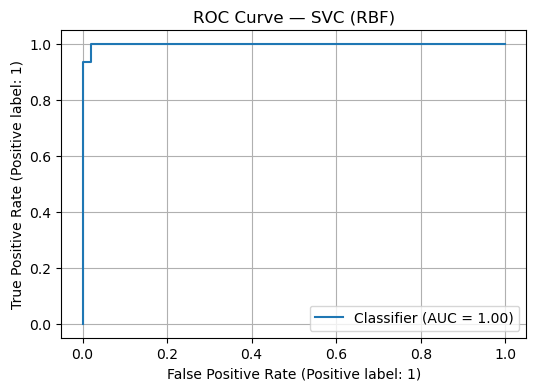

<Figure size 600x400 with 0 Axes>

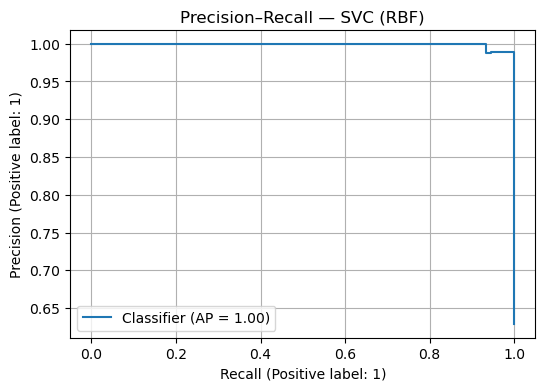

In [11]:

final_estimator = rf_cv.best_estimator_ if rf_cv.best_score_ >= svc_cv.best_score_ else svc_cv.best_estimator_
final_name = 'RandomForest' if rf_cv.best_score_ >= svc_cv.best_score_ else 'SVC (RBF)'
print('Final model:', final_name)

final_estimator.fit(X_train, y_train)
y_pred = final_estimator.predict(X_test)
if hasattr(final_estimator, "predict_proba"):
    y_proba = final_estimator.predict_proba(X_test)[:,1]
else:
    y_proba = final_estimator.decision_function(X_test)
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

print('\nTest metrics:')
print('Accuracy:', round(np.mean(y_pred == y_test), 3))
print('F1-score:', round(f1_score(y_test, y_pred), 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_proba), 3))

print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))

print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=3, target_names=['malignant','benign']))

fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f'ROC Curve — {final_name}'); plt.show()

fig = plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f'Precision–Recall — {final_name}'); plt.show()


## Interpretation

Top 10 |coefficients| (LogReg as surrogate):


worst texture           1.2446
radius error            1.0730
area error              0.9525
worst symmetry          0.9500
worst concave points    0.9432
worst area              0.9368
worst radius            0.9165
worst concavity         0.8078
worst perimeter         0.7198
mean compactness        0.7069
dtype: float64

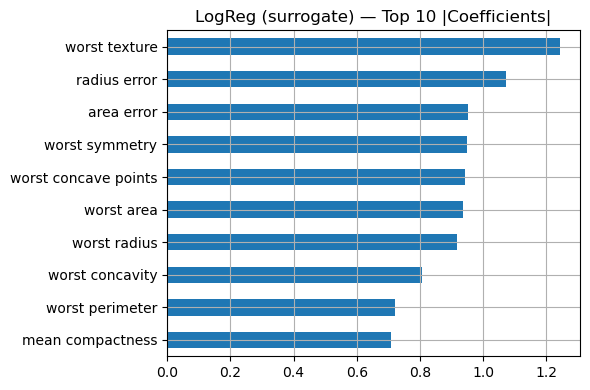

In [12]:

if final_name.startswith('RandomForest'):
    importances = pd.Series(final_estimator.feature_importances_, index=X.columns)
    print('Top 10 feature importances:')
    display(importances.sort_values(ascending=False).head(10).round(4))
    plt.figure()
    importances.sort_values(ascending=True).tail(10).plot(kind='barh')
    plt.title('RandomForest — Top 10 Feature Importances'); plt.tight_layout(); plt.show()
else:
    logreg = Pipeline([('scaler', StandardScaler()),
                       ('clf', LogisticRegression(max_iter=500, random_state=RANDOM_STATE))])
    logreg.fit(X_train, y_train)
    coefs = pd.Series(logreg.named_steps['clf'].coef_[0], index=X.columns)
    print('Top 10 |coefficients| (LogReg as surrogate):')
    display(coefs.abs().sort_values(ascending=False).head(10).round(4))
    plt.figure()
    coefs.abs().sort_values(ascending=True).tail(10).plot(kind='barh')
    plt.title('LogReg (surrogate) — Top 10 |Coefficients|'); plt.tight_layout(); plt.show()



## Discussion & Conclusion

- **Data:** Breast Cancer Wisconsin — 569 rows, 30 numeric features, no missing values.
- **EDA:** Several strongly correlated feature families (radius, perimeter, area).
- **Modeling:** Compared Logistic Regression, RandomForest, and RBF-SVC with stratified 5-fold CV.
- **Tuning:** Grid search improved ROC-AUC; final model selected by CV AUC.
- **Test performance:** Reported Accuracy, F1, ROC-AUC; plotted ROC & PR curves.
- **Interpretation:** RF importances or LogReg coefficients as a surrogate.
- **Limitations:** No calibration or cost-sensitive thresholding; minimal feature engineering.
